In [14]:
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../../')

# from model.get_model import get_model_kwargs, model_dict
from model.module_pomelo import POMELO_module
from utils.utils import to_cuda_inplace
from utils.utils import load_json, apply_transformations_and_normalize, apply_normalize
from utils.constants import config_path

from scipy.interpolate import griddata
import numpy as np
import rasterio
import torch
import os


In [15]:


targetreg = "bunia"
# targetreg = "goma"
dataroot = "/scratch2/metzgern/HAC/data/PopMapData/raw/timseries/"
outputdir = "/scratch2/metzgern/HAC/data/PopMapData/raw/timseries/{targetreg}/prediction1_poster".format(targetreg=targetreg)
targetroot = dataroot + "{}".format(targetreg)

# inference_times = [2022,2023]
inference_times = [2019, 2020, 2021, 2022, 2023]
# inference_times = [2020]
seasons = ["spring", "summer", "autumn", "winter"]
# seasons = ["spring", "summer"]
# seasons = ["spring"]

# define crop
# w = None
w = [150,950,620,975]
w = [150,750,620,975]
# w = [100,700,1100,2000]

# define params, UGA trained
# resume = [
#     "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_950_642/last_model.pth",
#     "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_949_640/last_model.pth",
#     "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_948_157/last_model.pth",
#     "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_947_559/last_model.pth",
#     "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_946_515/last_model.pth",
# ]

resume = [
    "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_696_451/last_model.pth",
    "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_693_727/last_model.pth",
    "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_693_194/last_model.pth",
    "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_693_526/last_model.pth",
    "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_692_518/last_model.pth",
    "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_690_622/last_model.pth",
    "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_689_611/last_model.pth",
    "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_686_402/last_model.pth",
    "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_681_376/last_model.pth",
    "/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_681_24/last_model.pth",
]

Sentinel1 = True
NIR = True
Sentinel2 = True

args_dict = {
    'input_channels': Sentinel1 * 2 + NIR * 1 + Sentinel2 * 3,
    'feature_dim': 4,
    'feature_extractor': "DDA",
    'occupancymodel': True,
    'pretrained': True,
    'dilation': False,
    'replace7x7': False,
    'parent': None,
    'down': 2,
    'experiment_folder': "",
    'useposembedding': False,
    'head': "v3",
    'grouped': False,
    'lempty_eps': 0.0,
    'dropout': 0.0,
    'sparse_unet': False,
    'buildinginput': False,
    'biasinit': False,
    'sentinelbuildings': True,
    'dda_dir':"model/DDA_model/checkpoints/"
}

if not os.path.exists(outputdir):
    os.makedirs(outputdir)


In [16]:

model = []
for _ in resume:
    thismodel = POMELO_module(**args_dict).cuda()
    model.append(thismodel)



trainable DDA SAR:  15041
trainable DDA OPT:  15185
Head:  9538
Loading urban extractor
trainable DDA SAR:  15041
trainable DDA OPT:  15185
Head:  9538
Loading urban extractor
trainable DDA SAR:  15041
trainable DDA OPT:  15185
Head:  9538
Loading urban extractor
trainable DDA SAR:  15041
trainable DDA OPT:  15185
Head:  9538
Loading urban extractor
trainable DDA SAR:  15041
trainable DDA OPT:  15185
Head:  9538
Loading urban extractor
trainable DDA SAR:  15041
trainable DDA OPT:  15185
Head:  9538
Loading urban extractor
trainable DDA SAR:  15041
trainable DDA OPT:  15185
Head:  9538
Loading urban extractor
trainable DDA SAR:  15041
trainable DDA OPT:  15185
Head:  9538
Loading urban extractor
trainable DDA SAR:  15041
trainable DDA OPT:  15185
Head:  9538
Loading urban extractor
trainable DDA SAR:  15041
trainable DDA OPT:  15185
Head:  9538
Loading urban extractor


In [17]:
len(model)

10

In [18]:

def resume_model( thismodel, path, j):
    """
    Input:
        path: path to the checkpoint
    """
    if not os.path.isfile(path):
        raise RuntimeError(f'No checkpoint found at \'{path}\'')

    # load checkpoint
    checkpoint = torch.load(path)
    thismodel.load_state_dict(checkpoint['model'])

    print(f'Checkpoint \'{path}\' loaded.')
    return thismodel

# checkpoint resume
for j, checkpoint in enumerate(resume): 
    model[j] = resume_model(model[j], checkpoint, j)
    model[j].eval()



Checkpoint '/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_696_451/last_model.pth' loaded.
Checkpoint '/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_693_727/last_model.pth' loaded.
Checkpoint '/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_693_194/last_model.pth' loaded.
Checkpoint '/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_693_526/last_model.pth' loaded.
Checkpoint '/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_692_518/last_model.pth' loaded.
Checkpoint '/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_690_622/last_model.pth' loaded.
Checkpoint '/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_689_611/last_model.pth' loaded.
Checkpoint '/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_686_402/last_model.pth' loaded.
Checkpoint '/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_681_376/last_model.pth' loaded.
Checkpoint '/scratch2/metzgern/HAC/POMELOv2_results/euler/experiment_681_24/last_model.pth'

In [19]:
# load normalization procedure stats
dataset_stats = load_json(os.path.join(config_path, 'dataset_stats', 'my_dataset_stats_unified_2A.json'))
for mkey in dataset_stats.keys():
    if isinstance(dataset_stats[mkey], dict):
        for key,val in dataset_stats[mkey].items():
            dataset_stats[mkey][key] = torch.tensor(val)
    else:
        dataset_stats[mkey] = torch.tensor(val)

In [20]:
def interpolate_nan(input_array):
    """
    Interpolate the NaN values in the input array using bicubic interpolation, extrapolating if necessary using nearest neighbor
    Input:
        input_array: input array with NaN values
    Output:
        input_array: input array with NaN values interpolated
    """

    # Create an array with True values for NaN positions (interpolation mask)
    nan_mask = np.isnan(input_array)
    known_points = np.where(~nan_mask)
    values = input_array[known_points]
    missing_points = np.where(nan_mask)

    if (~nan_mask).sum()< 4:
        print("all nan detected")
        return np.zeros_like(input_array)
    
    # interpolate the missing values
    interpolated_values = griddata(np.vstack(known_points).T, values, np.vstack(missing_points).T, method='nearest')

    # fillin the missing ones
    input_array[missing_points] = interpolated_values

    return input_array



In [21]:
season_average = True  # Switch to enable averaging over seasons

# inference
total = []
total_season = []
label = []
label_season = []
popdensemaps = []
popdensemaps_season = []
popdensemaps_std = []
popdensemaps_std_season = []

with torch.no_grad():
    for year in inference_times:
        seasonal_popdensemaps = []
        seasonal_popdensemaps_std = []

        for season in seasons:
            # read data
            sample = {}

            if year == 2023 and season in ["autumn", "winter"]:
                continue

            if Sentinel2:
                filepath = targetroot + "/{targetreg}{year}／S2A{season}/S2A{season}_{targetreg}{year}.tif".format(targetreg=targetreg, year=year, season=season)
                # print("Opening file:", filepath)
                with rasterio.open(filepath) as f:
                    s2 = f.read()
                    metadata = f.meta.copy()
                s2 = interpolate_nan(s2) 
                s2 = torch.from_numpy(s2).unsqueeze(0).float()
                if w is not None:
                    s2 = s2[:,:,w[0]:w[1],w[2]:w[3]]
                sample["S2"] = s2

            if Sentinel1:
                filepath = targetroot + "/{targetreg}{year}/S1{season}_{targetreg}{year}.tif".format(targetreg=targetreg, year=year, season=season)
                # print("Opening file:", filepath)
                with rasterio.open(filepath) as f:
                    s1 = f.read()
                    metadata = f.meta.copy()
                s1 = interpolate_nan(s1)
                s1 = torch.from_numpy(s1).unsqueeze(0).float()
                if w is not None:
                    s1 = s1[:,:,w[0]:w[1],w[2]:w[3]]
                sample["S1"] = s1

            sample = to_cuda_inplace(sample)
            sample = apply_transformations_and_normalize(sample,  transform=None, dataset_stats=dataset_stats, buildinginput=False, segmentationinput=False, empty_eps=0.0)
            
            popdense = torch.zeros((len(model), 1, sample["input"].shape[2], sample["input"].shape[3]))
            for i, thismodel in enumerate(model):
                print("Model", i)
                # print(sample["input"].shape)
                this_output = thismodel(sample, padding=False)
                popdense[i] = this_output["popdensemap"][0].cpu()

            popdense_mean = popdense.mean(dim=0)[0]
            seasonal_popdensemaps.append(popdense_mean)
            popdense_std = popdense.std(dim=0)[0]
            seasonal_popdensemaps_std.append(popdense_std)

            #collect the maps 
            popdensemaps.append(popdense_mean)
            popdensemaps_std.append(popdense_std)

            total.append(popdense_mean.sum())
            label.append("{year}-{season}".format(year=year, season=season))


            # If not averaging, save individual season results
            if not season_average:
                total.append(popdense_mean.sum())
                label.append("{year}-{season}".format(year=year, season=season))
                popdensemaps.append(popdense_mean)

            # save output
            metadata.update({"dtype": "float32", "count": 1, "compress": "lzw"})

            # for prediction save
            filepath = outputdir + "/pred_{targetreg}{year}{season}.tif".format(targetreg=targetreg, year=year, season=season)
            print("Saving file:", filepath)
            with rasterio.open(filepath, 'w', **metadata) as dst:
                dst.write(popdense_mean.cpu().numpy(), 1)

            # for uncertainty save
            filepath = outputdir + "/std_{targetreg}{year}{season}.tif".format(targetreg=targetreg, year=year, season=season)
            print("Saving file:", filepath)
            with rasterio.open(filepath, 'w', **metadata) as dst:
                dst.write(popdense_std.cpu().numpy(), 1)

        # If averaging, compute average over seasons and save
        if season_average and len(seasonal_popdensemaps) > 0:
            avg_popdense = torch.stack(seasonal_popdensemaps).mean(dim=0)
            avg_popdense_std = torch.stack(seasonal_popdensemaps_std).mean(dim=0)
            total_season.append(avg_popdense.sum().numpy())
            label_season.append("{year}".format(year=year))
            popdensemaps_season.append(avg_popdense)
            popdensemaps_std_season.append(avg_popdense_std)
            
            # Saving averaged results
            metadata.update({"dtype": "float32", "count": 1, "compress": "lzw"})

            # For prediction save
            filepath = outputdir + "/avg_pred_{targetreg}{year}.tif".format(targetreg=targetreg, year=year)
            print("Saving file:", filepath)
            with rasterio.open(filepath, 'w', **metadata) as dst:
                dst.write(avg_popdense.cpu().numpy(), 1)

            # For uncertainty save
            filepath = outputdir + "/avg_std_{targetreg}{year}.tif".format(targetreg=targetreg, year=year)
            print("Saving file:", filepath)
            with rasterio.open(filepath, 'w', **metadata) as dst:
                dst.write(avg_popdense_std.cpu().numpy(), 1)


Model 0
Model 1
Model 2
Model 3
Model 4
Model 5
Model 6
Model 7
Model 8
Model 9
Saving file: /scratch2/metzgern/HAC/data/PopMapData/raw/timseries/bunia/prediction1_poster/pred_bunia2019spring.tif
Saving file: /scratch2/metzgern/HAC/data/PopMapData/raw/timseries/bunia/prediction1_poster/std_bunia2019spring.tif
Model 0
Model 1
Model 2
Model 3
Model 4
Model 5
Model 6
Model 7
Model 8
Model 9
Saving file: /scratch2/metzgern/HAC/data/PopMapData/raw/timseries/bunia/prediction1_poster/pred_bunia2019summer.tif
Saving file: /scratch2/metzgern/HAC/data/PopMapData/raw/timseries/bunia/prediction1_poster/std_bunia2019summer.tif
Model 0
Model 1
Model 2
Model 3
Model 4
Model 5
Model 6
Model 7
Model 8
Model 9
Saving file: /scratch2/metzgern/HAC/data/PopMapData/raw/timseries/bunia/prediction1_poster/pred_bunia2019autumn.tif
Saving file: /scratch2/metzgern/HAC/data/PopMapData/raw/timseries/bunia/prediction1_poster/std_bunia2019autumn.tif
Model 0
Model 1
Model 2
Model 3
Model 4
Model 5
Model 6
Model 7
Mod

In [22]:
avg_popdense.shape

torch.Size([600, 355])

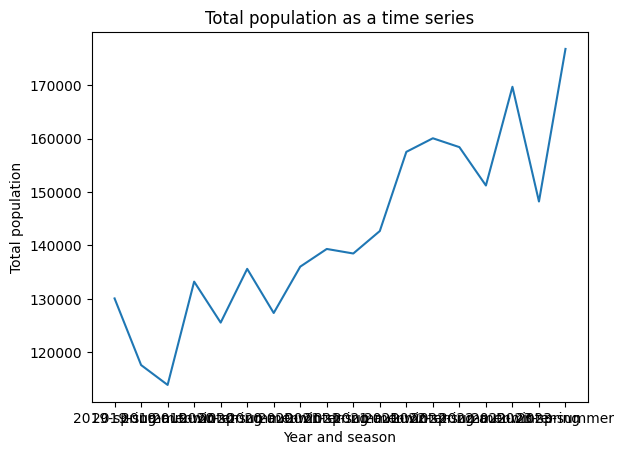

In [23]:
# plot total population as a time series, line plot using total and label
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

total = np.array(total)
label = np.array(label)

plt.plot(label, total)
plt.xlabel("Year and season")
plt.ylabel("Total population")
plt.title("Total population as a time series")
plt.show()

/tmp/ipykernel_2824305/1387165303.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


vmin: tensor(2.5248e-06)
vmax: tensor(5.3583)


/tmp/ipykernel_2824305/1387165303.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_std = cm.get_cmap('YlOrRd')


vmin_std: tensor(7.7428e-07)
vmax_std: tensor(5.4139)


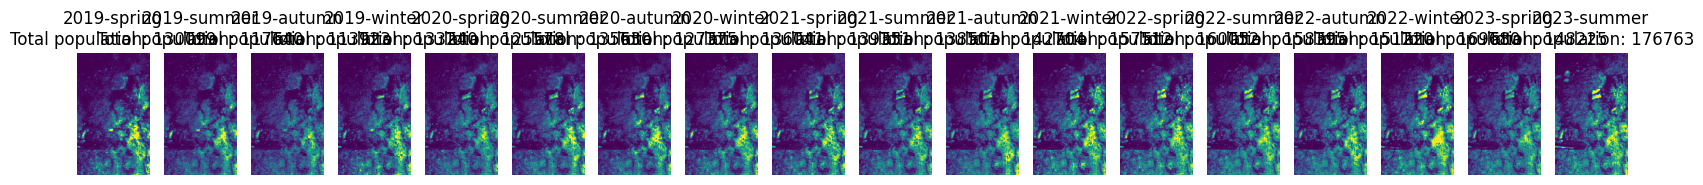

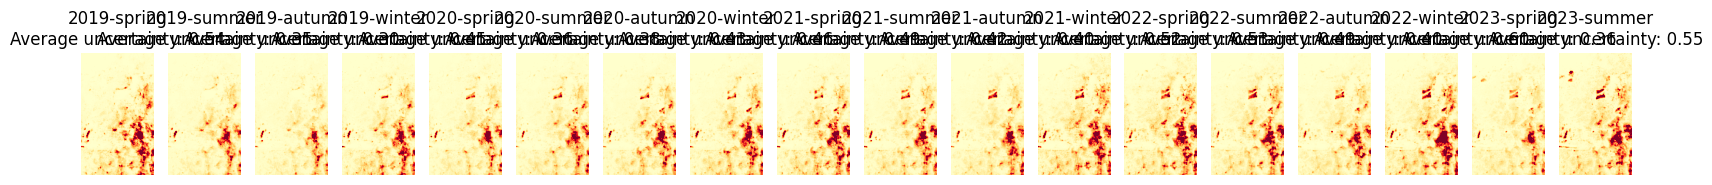

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# set colormap and vmin/vmax for popdensemaps
cmap = cm.get_cmap('viridis')
vmin = min([popdensemap.min() for popdensemap in popdensemaps])
vmax = max([popdensemap.max() for popdensemap in popdensemaps])
print("vmin:", vmin)
print("vmax:", vmax)
vmin = 0
vmax = 3.2

# plot popdensemaps
fig, axs = plt.subplots(1, len(popdensemaps), figsize=(20, 5))
for i, popdensemap in enumerate(popdensemaps):
    axs[i].imshow(popdensemap.cpu().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
    axs[i].set_title("{}\nTotal population: {}".format(label[i], int(round(total[i]))))
    axs[i].axis('off')

# set colormap and vmin/vmax for popdensemaps_std
cmap_std = cm.get_cmap('YlOrRd')
vmin_std = min([popdensemap_std.min() for popdensemap_std in popdensemaps_std])
vmax_std = max([popdensemap_std.max() for popdensemap_std in popdensemaps_std])
print("vmin_std:", vmin_std)
print("vmax_std:", vmax_std)
vmin_std = 0
vmax_std = 2

# plot popdensemaps_std
fig, axs = plt.subplots(1, len(popdensemaps_std), figsize=(20, 5))
for i, popdensemap_std in enumerate(popdensemaps_std):
    avg_std = (popdensemap_std**2).mean().sqrt()
    axs[i].imshow(popdensemap_std.cpu().numpy(), cmap=cmap_std, vmin=vmin_std, vmax=vmax_std)
    axs[i].set_title("{}\nAverage uncertainty: {:.2f}".format(label[i], avg_std))
    axs[i].axis('off')

plt.show()

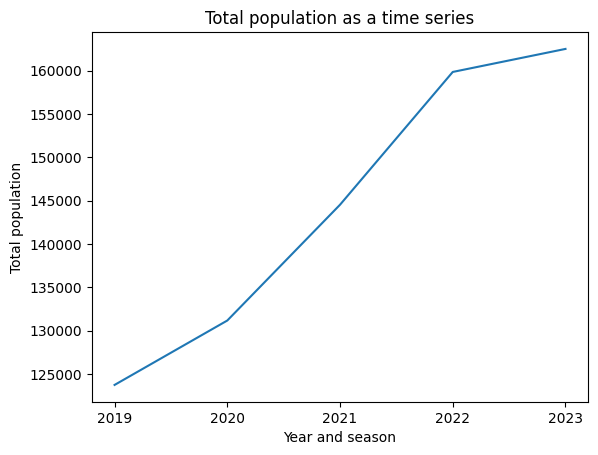

In [25]:
# plot total population as a time series, line plot using total and label
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

total_season = np.array(total_season)
label_season = np.array(label_season)

plt.plot(label_season, total_season)
plt.xlabel("Year and season")
plt.ylabel("Total population")
plt.title("Total population as a time series")
plt.show()

/tmp/ipykernel_2824305/1819614426.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


vmin: tensor(4.6725e-05)
vmax: tensor(4.2712)
Saved figure to  /scratch2/metzgern/HAC/data/PopMapData/raw/timseries/bunia/prediction1_poster/series_bunia.pdf
Saved figure to  /scratch2/metzgern/HAC/data/PopMapData/raw/timseries/bunia/prediction1_poster/series_bunia.png
vmin_std: tensor(1.4741e-05)
vmax_std: tensor(5.0716)


/tmp/ipykernel_2824305/1819614426.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_std = cm.get_cmap('YlOrRd')


Saved figure to  /scratch2/metzgern/HAC/data/PopMapData/raw/timseries/bunia/prediction1_poster/series_uncert_bunia.pdf
Saved figure to  /scratch2/metzgern/HAC/data/PopMapData/raw/timseries/bunia/prediction1_poster/series_uncert_bunia.png


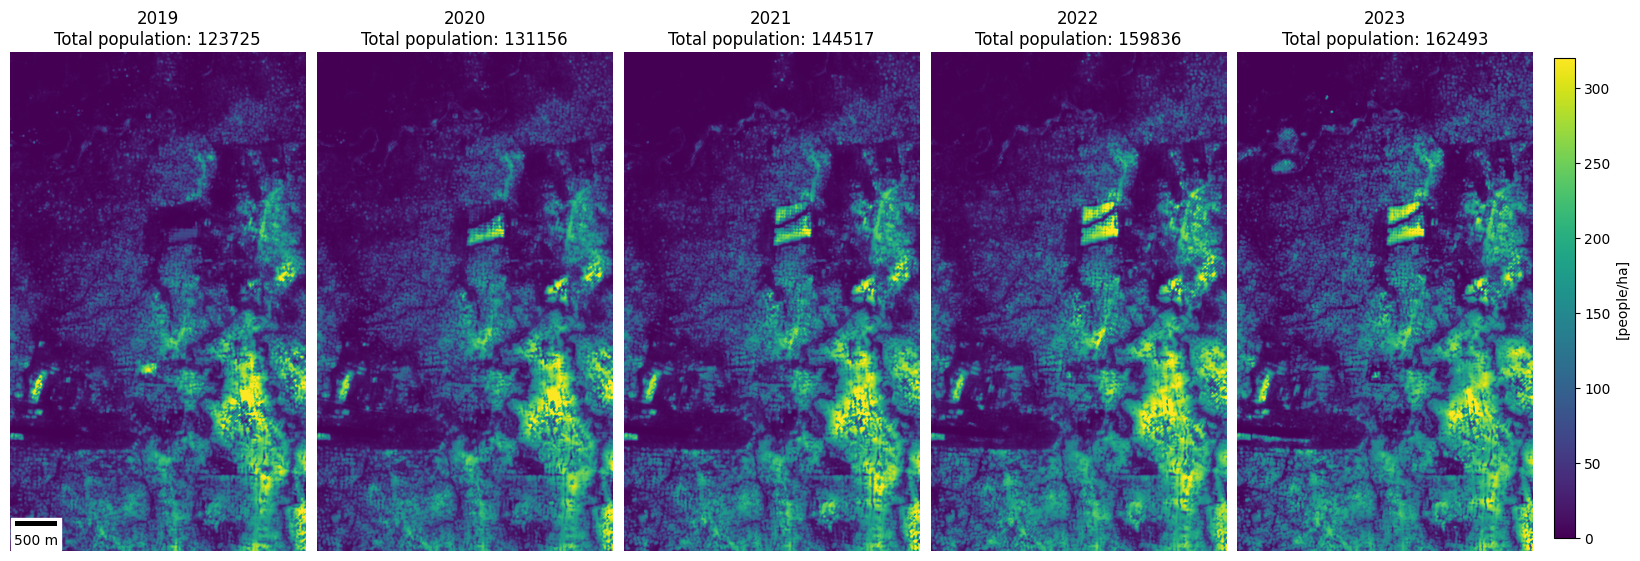

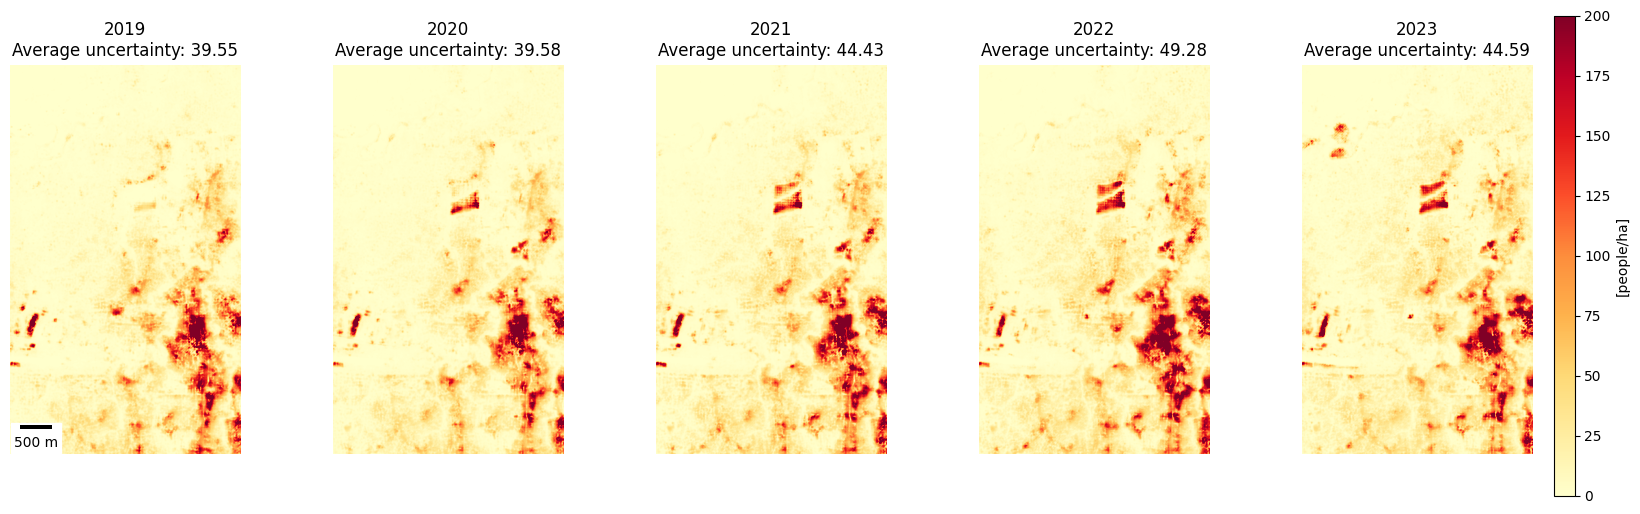

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar

# set colormap and vmin/vmax for popdensemaps
cmap = cm.get_cmap('viridis')
vmin = min([popdensemap.min() for popdensemap in popdensemaps_season])
vmax = max([popdensemap.max() for popdensemap in popdensemaps_season])
print("vmin:", vmin)
print("vmax:", vmax)
vmin = 0
vmax = 320

# plot popdensemaps
fig, axs = plt.subplots(1, len(popdensemaps_season), figsize=(21, 8))
for i, popdensemap in enumerate(popdensemaps_season):
    axs[i].imshow(popdensemap.cpu().numpy()*100, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[i].set_title("{}\nTotal population: {}".format(label_season[i], int(total_season[i])))
    axs[i].axis('off')
    if i == 0:
        scalebar = ScaleBar(10,  location=3) # 1 pixel = 0.2 meter
        axs[i].add_artist(scalebar)

# adjust spacing and add colorbar for popdensemaps
fig.subplots_adjust(right=0.85, wspace=0.04)
cbar_ax = fig.add_axes([0.86, 0.2, 0.01, 0.6])
cbar = fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), cax=cbar_ax)
cbar.set_label('[people/ha]')

plt.savefig(outputdir + "/series_{targetreg}.pdf".format(targetreg=targetreg), dpi=1200, bbox_inches='tight')
print("Saved figure to ", outputdir + "/series_{targetreg}.pdf".format(targetreg=targetreg))

# also save it as png
plt.savefig(outputdir + "/series_{targetreg}.png".format(targetreg=targetreg), dpi=1200, bbox_inches='tight')
print("Saved figure to ", outputdir + "/series_{targetreg}.png".format(targetreg=targetreg))


# set colormap and vmin/vmax for popdensemaps_std
cmap_std = cm.get_cmap('YlOrRd')
vmin_std = min([popdensemap_std.min() for popdensemap_std in popdensemaps_std_season])
vmax_std = max([popdensemap_std.max() for popdensemap_std in popdensemaps_std_season])
print("vmin_std:", vmin_std)
print("vmax_std:", vmax_std)
vmin_std = 0
vmax_std = 200

# plot popdensemaps_std
fig, axs = plt.subplots(1, len(popdensemaps_std_season), figsize=(21, 8))
for i, popdensemap_std in enumerate(popdensemaps_std_season):
    avg_std = (popdensemap_std**2).mean().sqrt()*100
    axs[i].imshow(popdensemap_std.cpu().numpy()*100, cmap=cmap_std, vmin=vmin_std, vmax=vmax_std)
    axs[i].set_title("{}\nAverage uncertainty: {:.2f}".format(label_season[i], avg_std))
    axs[i].axis('off')
    if i == 0:
        scalebar = ScaleBar(10, location=3) # 1 pixel = 0.2 meter
        axs[i].add_artist(scalebar)
# scalebar = ScaleBar(10) # 1 pixel = 0.2 meter
# plt.gca().add_artist(scalebar, location=3)

# adjust spacing and add colorbar for popdensemaps_std 
fig.subplots_adjust(right=0.85, wspace=0.4)
cbar_ax = fig.add_axes([0.86, 0.2, 0.01, 0.6])
cbar = fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(vmin=vmin_std, vmax=vmax_std), cmap=cmap_std), cax=cbar_ax)
cbar.set_label('[people/ha]')


#save figure
plt.savefig(outputdir + "/series_uncert_{targetreg}.pdf".format(targetreg=targetreg), dpi=1200, bbox_inches='tight')
print("Saved figure to ", outputdir + "/series_uncert_{targetreg}.pdf".format(targetreg=targetreg))

# also save it as png
plt.savefig(outputdir + "/series_uncert_{targetreg}.png".format(targetreg=targetreg), dpi=1200, bbox_inches='tight')
print("Saved figure to ", outputdir + "/series_uncert_{targetreg}.png".format(targetreg=targetreg))
plt.show()
